# Imports

In [62]:
import os
from platypus import (
    NSGAII,
    Problem,
    Real,
    Integer,
    nondominated_sort,
    SBX,
    PM,
    GAOperator,
    Evaluator,
    run_job,
    Archive,
    Solution,
    nondominated,
    InjectedPopulation,
    Mutation,
    NSGAIII,
    Variator,
)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
from shapely.geometry import Polygon, shape, Point
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity
import random
import copy
from joblib import Parallel, delayed
import multiprocessing
from OSGridConverter import latlong2grid, grid2latlong
import matplotlib
import plotly.express as px
import seaborn


In [63]:
# set working directory
os.chdir("C:/Users/zacha/Documents/GitHub/plymouth-university-proj518")
print(os.getcwd())


C:\Users\zacha\Documents\GitHub\plymouth-university-proj518


## Get corners of given site
* In order to relate distance in metres to latitude/longitude, coordinates are mapped to easting/northing OS grid.
* This grid maps coordinates to 10x10m resolution, allowing metre distance offset to be calculated, then converted back into latitude/longitude. 

In [64]:
def getCorners(lon, lat, turbnum):
    """Get the corners of a square with a given centre and side length.

    Parameters
    ----------
    lon : float
        Longitude of the centre of the square.
    lat : float
        Latitude of the centre of the square.
    distance : float
        Side length of the square.

    Returns
    -------
    list
        List of the corners of the square.
    """

    lonRads = np.radians(lon)
    latRads = np.radians(lat)

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # N turbines * 500m radius, into km
    distance = int(length_turbnum * 0.5)

    corners = []

    for bearing in [45, 135, 225, 315]:
        bearingRads = np.radians(bearing)

        maxLatRads = np.arcsin(
            np.sin(latRads) * np.cos(distance / 6371)
            + np.cos(latRads) * np.sin(distance / 6371) * np.cos(bearingRads)
        )
        maxLonRads = lonRads + np.arctan2(
            np.sin(bearingRads) * np.sin(distance / 6371) * np.cos(latRads),
            np.cos(distance / 6371) - np.sin(latRads) * np.sin(maxLatRads),
        )

        maxLat = np.degrees(maxLatRads)
        maxLon = np.degrees(maxLonRads)

        corners.append([maxLon, maxLat])

    return corners


## Decode genetic code into dataframe

In [65]:
def decode_solutions(sols):
    """Decode the solutions from Platypus.

    Parameters
    ----------
    sols : list
        List of solutions from Platypus.

    Returns
    -------
    pd.DataFrame
        Dataframe of decoded solutions.
    """

    problem = sols[0].problem

    df = pd.DataFrame(
        columns=[
            "rotation",
            "center_lon",
            "center_lat",
            "turbnum",
            "Velocity Potential",
            "Stability",
            "Shipping Density",
            "Wrecks and Obstructions",
            "depth",
            "Rank",
            "Rank marker",
            "Wrecks marker",
            "Wrecks color",
            "Name",
            "IsKnown",
        ]
    )

    markers = [
        "o",
        "v",
        "^",
        ">",
        "<",
        "s",
        "p",
        "P",
        "*",
        "h",
        "H",
        "D",
        "d",
        "X",
        "x",
        "1",
        "2",
        "3",
        "4",
        "8",
    ]

    colors = ["r", "g", "b", "c", "m", "y", "k", "grey"]

    nondominated_sort(sols)

    for i, solution in enumerate(sols):
        if hasattr(solution, "is_known"):
            if problem.types[3].decode(solution.variables[3]) == 174:
                mark = "o"
                name = "Hornsea 1"
            else:
                mark = "v"
                name = "Hornsea 2"

            is_known = True

        elif hasattr(solution, "kneepoint"):
            mark = "s"
            name = "Knee-point"
            is_known = False

        else:
            name = str(i)
            mark = "*"
            is_known = False
            
        decision_vars = []
        decoders = problem.types
        for i, var in enumerate(solution.variables):
            decoder = decoders[i]
            decision_vars += [
                decoder.decode(var),
            ]

        # mark relative to integer of rank
        rank_marker = markers[int(solution.rank)]

        wrecks_marker = markers[int(solution.objectives[3])]
        wrecks_color = colors[int(solution.objectives[3])]

        depth = solution.constraints[1]

        is_known = hasattr(solution, "is_known")

        df.loc[len(df.index)] = [
            *decision_vars,
            *solution.objectives,
            depth,
            solution.rank,
            rank_marker,
            wrecks_marker,
            wrecks_color,
            name,
            is_known,
        ]
    
    # remove solutions with an invalid value
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # flip the velocity potential
    df["Velocity Potential"] = -df["Velocity Potential"]

    # filter out duplicate rotation/lon/lat/turbnum combinations
    df = df.drop_duplicates()
    
    return df

# Problem definition
* Define the parameters for solutions:
1. Longitude of the site.
2. Latitude of the site.
3. Rotation of the site (offset from 0 degrees / north).
4. Number of turbines in the site (as estimate for site area).

* Define objectives / method to evaluate fitness.
1. Mean velocity potential.
2. Mean standard deviation of velocity potential (stability).
3. Wreckages / obstructions within the site boundary.
4. Shipping density of the site.

* Define constraints.
1. Intersection with the search space (perform error correction if >40% of naive shape is valid).
2. Maximum depth of seabed within site must be >= -40m.

In [66]:
class OWF(Problem):
    def __init__(
        self,
        lon_limits,
        lat_limits,
        day_limits,
        turbnum_limits,
        data,
        map_polygon,
        wrecks_and_obstructions,
        shipping_density,
    ):
        """Initialise the problem.

        Parameters
        ----------
        lon_limits : list
            List of the longitude limits of the site.
        lat_limits : list
            List of the latitude limits of the site.
        day_limits : list
            List of the day limits of the site.
        turbnum_limits : list
            List of the turbine number limits of the site.
        data : pandas.DataFrame
            Dataframe containing velocity potential variations over time + depth data for given datapoints.
        map_polygon : shapely.geometry.Polygon
            Polygon of the search space boundary.
        wrecks_and_obstructions : shapely.geometry.Polygon
            Polygon of the wrecks and obstructions within the site.
        shipping_density : pandas.DataFrame
            Dataframe containing shipping density data for given datapoints.

        Returns
        -------
        None

        """

        super(OWF, self).__init__(4, 4, 2)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits
        self.day_limits = day_limits
        self.turbnum_limits = turbnum_limits

        self.data = data
        self.map_polygon = map_polygon
        self.wrecks_and_obstructions = wrecks_and_obstructions
        self.shipping_density = shipping_density

        self.types[:] = [
            # polygon is rotated by rotation angle
            Real(0, 360),
            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon
            # number of turbines as analogy for area of farm
            Integer(self.turbnum_limits[0], self.turbnum_limits[1]),
        ]

        # direction of optimisation (minimise or maximise objectives)
        self.directions[:] = [
            Problem.MINIMIZE,  # minimise inverse of Velocity Potential (i.e. maximise Velocity Potential)
            Problem.MINIMIZE,  # minimise inverse of velocity potential density (i.e. maximise velocity potential density)
            Problem.MINIMIZE,  # minimise shipping density at solution
            Problem.MINIMIZE,  # minimise wrecks and obstructions within solution
        ]

        # constraints
        self.constraints[:] = [
            "==1.0",  # constrain valid shapes to have 100% intersection with site boundary
            ">-40",  # contrain depth of site to max. 40m (invert bc depth goes -inf -> 0)
        ]

    def evaluate(self, solution):
        """Evaluate the problem.

        Parameters
        ----------
        solution : list
            List of the solution variables.

        Returns
        -------
        None

        """

        # get variables from solution
        x = solution.variables[:]

        rotation = x[0]
        center = lon, lat = x[1:3]
        turbnum = x[3]

        q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)

        def rotate(points, origin, angle):
            """Rotate a point counterclockwise by a given angle around a given origin.

            The angle should be given in radians.
            """
            xy = (points - origin) * np.exp(complex(0, angle)) + origin
            return xy.real, xy.imag

        q1_coord = rotate(
            complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation)
        )
        q2_coord = rotate(
            complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation)
        )
        q3_coord = rotate(
            complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation)
        )
        q4_coord = rotate(
            complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation)
        )

        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
        shapely_polygon = Polygon(points)

        intersection = shapely_polygon.intersection(self.map_polygon)

        if intersection.area > 0.4 and self.map_polygon.contains(Point(lon, lat)):
            target = shapely_polygon.area
            maxR = pow(target / 3.141593, 0.5)
            tolerance = 0.00001
            lower_bound = 0.0001
            outer_limit, inner_limit = (
                20,
                20,
            )  # max number of iterations for outer and inner loops before giving up
            outer_count = 0

            # iterate till area outside of map polygon is less than lower bound (redistributed back inside polygon)
            while True:
                if 1 - (intersection.area / shapely_polygon.area) > lower_bound:

                    low, high = 0, maxR

                    while True:
                        middle = 0.5 * (low + high)

                        newPolygon = intersection.buffer(middle)

                        if (high - low) < tolerance:
                            break

                        if newPolygon.area < target:
                            low = middle
                        else:
                            high = middle

                    shapely_polygon = newPolygon

                else:
                    points = np.array(
                        shapely_polygon.exterior.coords
                    )  # exit once difference is empty or below lower bound
                    break

                outer_count += 1
                if outer_count > outer_limit:
                    points = np.array(shapely_polygon.exterior.coords)
                    break

                intersection = shapely_polygon.intersection(self.map_polygon)

        # use deformed points to create new polygon for data extraction
        polygon = path.Path(points)

        # get bathymetryic and velocity potential data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]

        # dataframe is empty, because no data at that location (out of bounds / too small)
        if data_polygon.empty:
            depth = -np.inf
            velocity_potential_mean = np.inf
            velocity_potential_stability = np.inf
        else:
            # get max depth from bathymetric data polygon (negatives, so find min)
            # with contraints, ensure turbines can be placed in any section of area
            depth = data_polygon["Depth"].min()

            velocity_potential = data_polygon.drop(["Lon", "Lat", "Depth"], axis=1)

            velocity_potential_stability = velocity_potential.std(axis=1).mean()

            velocity_potential_mean = velocity_potential.mean(axis=1).mean()

        # get all wrecks and obstructions within polygon
        wrecks_and_obstructions = self.wrecks_and_obstructions[
            polygon.contains_points(
                self.wrecks_and_obstructions[["longitude", "latitude"]].values
            )
        ]

        # fitness is number of wrecks or obstructions inside polygon (less is better)
        wrecks_and_obstructions = len(wrecks_and_obstructions)

        # get shipping density by locating density polygon which contains center point
        shipping_densities = []
        for i, row in self.shipping_density.iterrows():
            # test if center is within row['polygon']
            if row["polygon"].contains_point(center):
                # contribution of shipping density per grid square is based on intersection with that grid square
                shipping_polygon_intersection = (
                    shapely_polygon.intersection(row["shapely_polygon"]).area
                    / shapely_polygon.area
                )
                shipping_densities.append(
                    row["yearly_avg"] * shipping_polygon_intersection
                )

        # catch out of bounds errors
        if len(shipping_densities) == 0:
            shipping_density = np.inf
        else:
            shipping_density = np.mean(shipping_densities)

        # calculate intersection area between map polygon and solution polygon
        intersection = (
            shapely_polygon.intersection(self.map_polygon).area / shapely_polygon.area
        )

        solution.objectives[:] = [
            -velocity_potential_mean,  # negate to maximise
            velocity_potential_stability,
            shipping_density,
            wrecks_and_obstructions,
        ]

        solution.constraints[:] = [
            intersection,
            depth,
        ]


# Data

## Load data

In [67]:
# Uk east coast velocity potential and bathymetry data
data = pd.read_csv("data/UK east coast velocity potential bathymetry.csv")

# NOTE: experimentally defined, enclosing area of map with depth >40m
lat_range = (53.486257927, 54.1)
lon_range = (0.5, 2.5571098)
days_range = (0, 228)

# UK east coast edge points alpha 17.5 data
# read map polygon coords and create polygon
polygon_df = pd.read_csv("data/UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

map_polygon = Polygon(polygon_np)

# UK east coast wrecks and obstructions
wrecks_and_obstructions = pd.read_csv("data/UK east coast wrecks and obstructions.csv")

# UK east coast shipping density (2015)
shipping_density = pd.read_csv("data/UK east coast shipping density 2015.csv")

shipping_density["corner"] = shipping_density["polygon"].apply(
    lambda x: eval(x)[0]
)  # get first corner of polygon
shipping_density["shapely_polygon"] = shipping_density["polygon"].apply(
    lambda x: Polygon(eval(x))
)  # convert polygon to shapely polygon
shipping_density["polygon"] = shipping_density["polygon"].apply(
    lambda x: path.Path(eval(x))
)  # convert polygon to matplotlib path

# UK east coast wind energy locations
# Rotation of known sites is optimised, on assumption real site will optimally use surrounding resources similarly.
known_owf_locations = pd.read_csv(
    "data/UK east coast optimised wind known energy locations.csv"
)

turbnum_range = (165, 174)  # min max turbnums in known truthes

# UKHO ADMIRALTY bathymetry UK east coast
file = "data/UKHO ADMIRALTY bathymetry UK east coast.csv"
admiralty_df = pd.read_csv(file, sep=",")
admiralty_df = admiralty_df[admiralty_df["Depth"] > -40]

# UK east coast velocity potential mean
mean_velocity_potential = pd.read_csv(
    "data/UK east coast velocity potential mean.csv", sep=","
)

# UK east coast velocity potential std
velocity_potential_stability = pd.read_csv(
    "data/UK east coast velocity potential std.csv", sep=","
)


## Data visualisation

c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


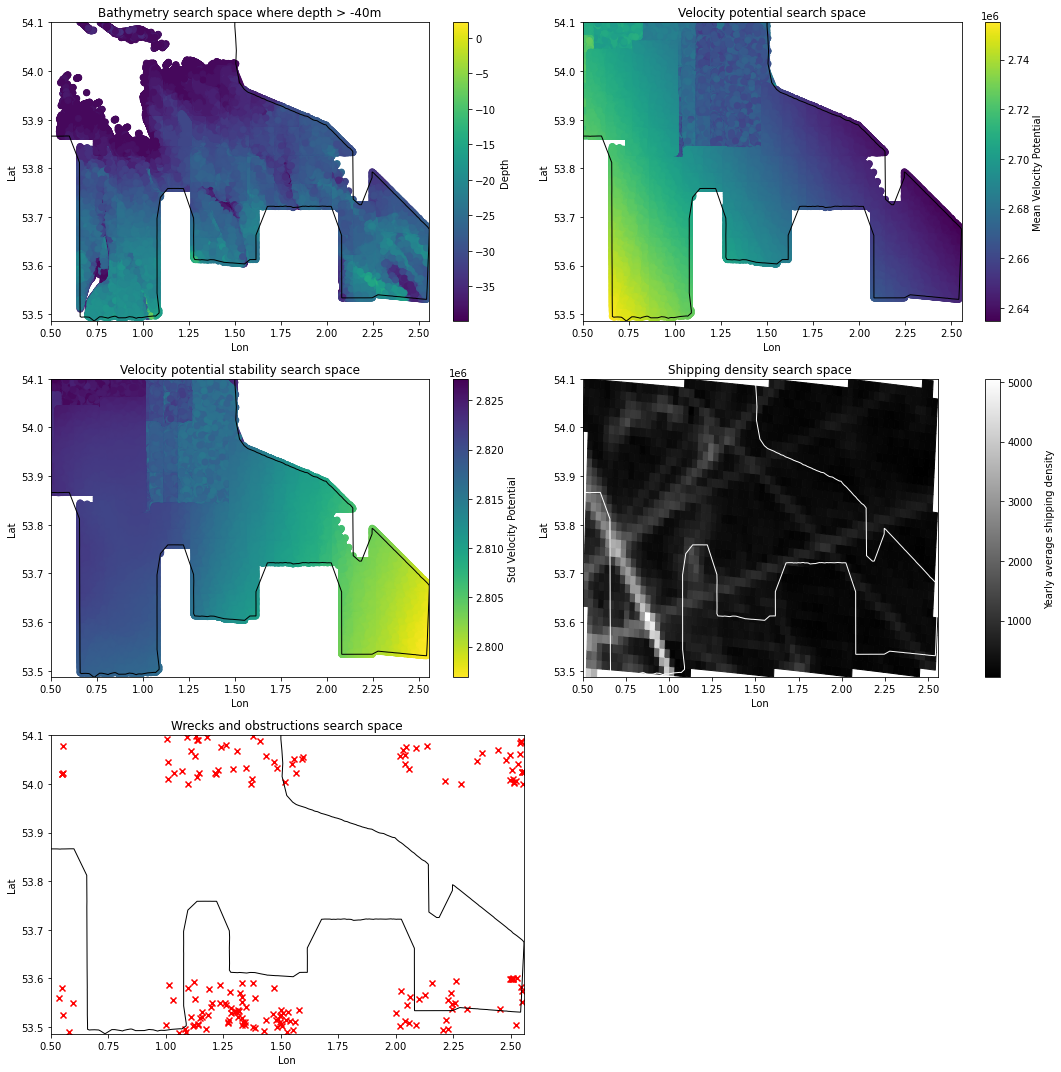

In [68]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# BATHYMETRY
ax = axes[0, 0]
ax.set_title("Bathymetry search space where depth > -40m")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(
    admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis"
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label("Depth")

# VELOCITY POTENTIAL
ax = axes[0, 1]
ax.set_title("Velocity potential search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(
    mean_velocity_potential["Lon"],
    mean_velocity_potential["Lat"],
    c=mean_velocity_potential["Mean Velocity Potential"],
    cmap="viridis",
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label("Mean Velocity Potential")

# VELOCITY POTENTIAL STABILITY
ax = axes[1, 0]
ax.set_title("Velocity potential stability search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(
    velocity_potential_stability["Lon"],
    velocity_potential_stability["Lat"],
    c=velocity_potential_stability["Std Velocity Potential"],
    cmap="viridis_r",
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label("Std Velocity Potential")

# WRECKS AND OBSTRUCTIONS
ax = axes[2, 0]
ax.set_title("Wrecks and obstructions search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.scatter(
    wrecks_and_obstructions["longitude"],
    wrecks_and_obstructions["latitude"],
    c="red",
    marker="x",
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# SHIPPING DENSITY
ax = axes[1, 1]
ax.set_title("Shipping density search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
minc, maxc = shipping_density["yearly_avg"].min(), shipping_density["yearly_avg"].max()
# calculate steps between min and max
diff = maxc - minc
for idx, row in shipping_density.iterrows():
    polygon = row["shapely_polygon"]

    # get percentage colours[idx] is between min and max
    i = (row["yearly_avg"] - minc) / diff
    rgb = (int(255 * i), int(255 * i), int(255 * i))
    html = "#%02x%02x%02x" % rgb

    patch = PolygonPatch(polygon, fc=html, ec=html, fill=True)
    ax.add_patch(patch)
ax.add_patch(PolygonPatch(map_polygon, fc="#000000", ec="#ffffff", fill=False))
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cmap = matplotlib.cm.binary_r
norm = matplotlib.colors.Normalize(
    vmin=shipping_density["yearly_avg"].min(), vmax=shipping_density["yearly_avg"].max()
)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.1)
cbar.set_label("Yearly average shipping density", labelpad=12.0)

# remove empty subplot
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


# Optimisation

In [69]:
# load the problem
problem = OWF(
    lat_limits=lat_range,
    lon_limits=lon_range,
    day_limits=days_range,
    turbnum_limits=turbnum_range,
    data=data,
    map_polygon=map_polygon,
    wrecks_and_obstructions=wrecks_and_obstructions,
    shipping_density=shipping_density,
)


## Evaluate known solutions

In [70]:
class SelectorSkip(object):
    """A selector that returns the population as is. This is used to skip the selection step in the genetic algorithm.
    """
    
    def __init__(self):
        super(SelectorSkip, self).__init__()
        
    def select(self, n, population):
        """Selects n individuals from the population.

        :param n: The number of individuals to select.
        :param population: The population from which to select.
        :returns: A list of selected individuals.
        """

        # handle case where population == number of parents (2)
        assert len(population) == n
        return population
    

In [71]:
class GASkip(Variator):
    """A genetic algorithm that skips crossover and mutation, keeping solutions static + only evaluating."""

    def __init__(self):
        super(GASkip, self).__init__(0)

    def evolve(self, parents):
        """Skips the evolution step, copying parents directly into children population.

        :param parents: The parents to evolve.
        :returns: A list of children.
        """

        children = []
        for parent in parents:
            child = copy.deepcopy(parent)
            children.append(child)

        return children


In [72]:
known_owf_solutions = []

for i, row in known_owf_locations.iterrows():
    sol = Solution(problem)
    setattr(sol, "is_known", True)
    turbnum = problem.types[3].encode(row["turbnum"])
    sol.variables = [row["rotation"], row["center_lon"], row["center_lat"], turbnum]
    known_owf_solutions.append(sol)

known_optimiser = NSGAII(
    problem,
    population_size=2,
    generator=InjectedPopulation(known_owf_solutions),
    selector=SelectorSkip(),
    variator=GASkip(),
)
known_optimiser.run(1)

known_solutions = known_optimiser.result
known_solutions_decoded = decode_solutions(known_solutions)

known_solutions_decoded # visualise solutions

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,Rank,Rank marker,Wrecks marker,Wrecks color,Name,IsKnown
0,49.0,1.422626,53.681258,174,2.690312e+06,2.814096e+06,52.433040,0,-64.0,1,v,o,r,Hornsea 1,True
1,247.0,1.541901,53.959745,165,2.662278e+06,2.815642e+06,10.534137,1,-39.7,0,o,v,g,Hornsea 2,True


## Optimise new solutions
* 5000 generations locates the optimal knee-point solution, whilst 10,000 optimises it further to primarily shipping density (but other optimisations are made).

In [73]:
algorithm = NSGAIII(problem, variator=GAOperator(SBX(), PM()), divisions_outer=12)
algorithm.run(10000)


c:\Users\zacha\miniconda3\lib\site-packages\platypus\core.py:1108: RuntimeWarning: invalid value encountered in double_scalars
  sorted_solutions[j].crowding_distance += diff / (max_value - min_value)
c:\Users\zacha\miniconda3\lib\site-packages\platypus\tools.py:101: RuntimeWarning: invalid value encountered in double_scalars
  alpha = A[i][p] / A[p][p]


In [74]:
# get feasible and nondominated solutions
feasible_solutions = [s for s in algorithm.result if s.feasible]
print(f"Feasible solutions: {len(feasible_solutions)}")

nondominated(feasible_solutions)

results = decode_solutions(feasible_solutions)


Feasible solutions: 456


In [75]:
# copy the data
results_max_scaled = results.copy()

# apply min/max normalization
for column in [
    "Velocity Potential",
    "Stability",
    "Shipping Density",
    "Wrecks and Obstructions",
]:
    column_max = results_max_scaled[column].abs().max()
    column_max = 1 if column_max == 0 else column_max
    results_max_scaled[column] = results_max_scaled[column] / column_max

# add new column "objectives sum" that sums ['Velocity Potential', 'Stability', 'Shipping Density', 'Wrecks and Obstructions']
results_max_scaled["objectives sum"] = results_max_scaled[
    ["Velocity Potential", "Stability", "Shipping Density", "Wrecks and Obstructions"]
].sum(axis=1)

display(results_max_scaled)


,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,Rank,Rank marker,Wrecks marker,Wrecks color,Name,IsKnown,objectives sum
0,136.614296,1.502167,53.800182,171,0.979367,0.997757,0.059262,0.000000,-33.0,0,o,o,r,0,False,2.036387
1,346.895659,2.307385,53.709918,167,0.967806,0.993359,0.037504,0.000000,-33.0,0,o,o,r,1,False,1.998669
2,99.645287,2.356101,53.613493,167,0.969741,0.992787,0.049329,0.000000,-36.0,0,o,o,r,2,False,2.011858
3,136.614296,1.502167,53.800182,171,0.979367,0.997757,0.059262,0.000000,-33.0,0,o,o,r,3,False,2.036387
4,52.548630,0.980348,53.598080,171,0.997178,0.999367,0.191655,0.142857,-34.0,0,o,v,g,4,False,2.331056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,103.143193,1.504196,53.815409,173,0.978961,0.997770,0.057290,0.000000,-34.0,0,o,o,r,451,False,2.034022
452,129.554222,1.502311,53.812750,171,0.979022,0.997775,0.059244,0.000000,-34.0,0,o,o,r,452,False,2.036042
453,335.042343,2.320862,53.614007,167,0.970334,0.992949,0.098664,0.000000,-36.0,0,o,o,r,453,False,2.061947
454,148.853108,2.316950,53.609749,171,0.970544,0.992954,0.098674,0.000000,-35.0,0,o,o,r,454,False,2.062172


In [76]:
minimise_solutions = []

kneepoint_idx = results_max_scaled[["objectives sum"]].idxmin()["objectives sum"]
print(f"Knee point index: {kneepoint_idx}")

most_minismising = feasible_solutions[kneepoint_idx]
# give most minimising an identifier
setattr(most_minismising, "kneepoint", True)
minimise_solutions.append(most_minismising)

print(most_minismising.constraints)


Knee point index: 188
[1.0, -29.3]


In [77]:
# generate solution objects for known locations
for sol in known_solutions:
    setattr(sol, "is_known", True)  # mark solution as known solution

# combine existing solutions with nondominated solutions and rank
combined_solutions = [*known_solutions, *minimise_solutions]

nondominated_sort(combined_solutions)

combined_results = decode_solutions(combined_solutions)
combined_results

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,Rank,Rank marker,Wrecks marker,Wrecks color,Name,IsKnown
0,49.000000,1.422626,53.681258,174,2.690312e+06,2.814096e+06,52.433040,0,-64.0,2,^,o,r,Hornsea 1,True
1,247.000000,1.541901,53.959745,165,2.662278e+06,2.815642e+06,10.534137,1,-39.7,1,v,v,g,Hornsea 2,True
2,348.192542,2.399824,53.675322,167,2.641648e+06,2.800567e+06,9.089156,0,-29.3,0,o,o,r,Knee-point,False


# Pareto fronts


## Nondominated evolved front

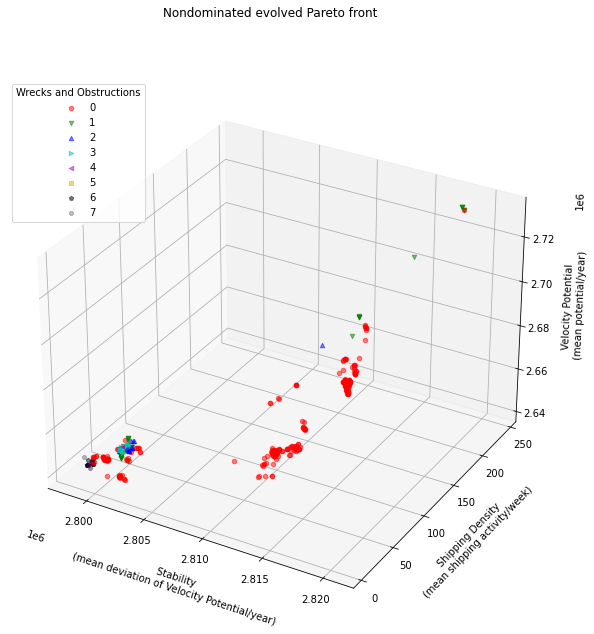

In [78]:
# Visualizing 5-D mix data using bubble charts
# leveraging the concepts of hue, marker and depth
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

t = fig.suptitle("Nondominated evolved Pareto front")

# order results by Wreck and Obstructions
results = results.sort_values(by=["Wrecks and Obstructions"])

for idx, row in results.iterrows():
    ax.scatter(
        row["Stability"],
        row["Shipping Density"],
        row["Velocity Potential"],
        label=str(row["Wrecks and Obstructions"]),
        marker=row['Wrecks marker'],
        c=row['Wrecks color'],
        alpha=0.5,
    )

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(), loc="best", title="Wrecks and Obstructions"
)

ax.set_xlabel("Stability \n(mean deviation of Velocity Potential/year)", labelpad=12.0)
ax.set_ylabel("Shipping Density \n(mean shipping activity/week)", labelpad=12.0)
ax.set_zlabel("Velocity Potential \n(mean potential/year)", labelpad=12.0)

plt.show()


## Existing solutions vs Nondominated evolved solutions

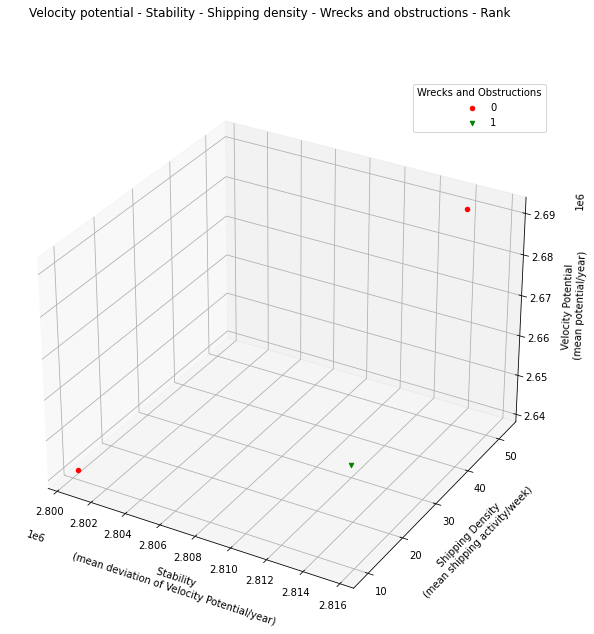

In [79]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

t = fig.suptitle(
    "Velocity potential - Stability - Shipping density - Wrecks and obstructions - Rank"
)

for idx, row in combined_results.iterrows():
    ax.scatter(
        row["Stability"],
        row["Shipping Density"],
        row["Velocity Potential"],
        label=str(row["Wrecks and Obstructions"]),
        marker=row['Wrecks marker'],
        c=row['Wrecks color'],
    )

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(), loc="best", title="Wrecks and Obstructions"
)

ax.set_xlabel("Stability \n(mean deviation of Velocity Potential/year)", labelpad=12.0)
ax.set_ylabel("Shipping Density \n(mean shipping activity/week)", labelpad=12.0)
ax.set_zlabel("Velocity Potential \n(mean potential/year)", labelpad=12.0)

plt.show()


# Visualisation

### Multi-faceted visualisation

1. Bathymetric data
2. Mean velocity potential
3. Velocity potential stability
4. Shipping density
5. Wrecks/obstructions

In [80]:
boundary_patches = []

for idx, row in combined_results.iterrows():
    rotation = row["rotation"]
    lon, lat = row["center_lon"], row["center_lat"]
    turbnum = row["turbnum"]

    q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)

    def rotate(points, origin, angle):
        xy = (points - origin) * np.exp(complex(0, angle)) + origin
        return xy.real, xy.imag

    q1_coord = rotate(
        complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation)
    )
    q2_coord = rotate(
        complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation)
    )
    q3_coord = rotate(
        complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation)
    )
    q4_coord = rotate(
        complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation)
    )

    p = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

    polygon = Polygon(p)

    target = polygon.area
    maxR = pow(target / 3.141593, 0.5)
    tolerance = 0.00001
    lower_bound = 0.0001
    outer_limit, inner_limit = (
        20,
        20,
    )  # max number of iterations for outer and inner loops before giving up
    outer_count, inner_count = 0, 0

    # iterate till area outside of map polygon is less than lower bound (redistributed back inside polygon)
    while True:
        intersection = polygon.intersection(map_polygon)

        if 1 - (intersection.area / polygon.area) > lower_bound:

            low, high = 0, maxR

            inner_count = 0
            while True:
                middle = 0.5 * (low + high)

                newPolygon = intersection.buffer(middle)

                if (high - low) < tolerance:
                    break

                if newPolygon.area < target:
                    low = middle
                else:
                    high = middle

                inner_count += 1
                if inner_count > inner_limit:
                    break

            polygon = newPolygon
        else:
            break  # exit once difference is empty or below lower bound

        outer_count += 1
        if outer_count > outer_limit:
            break

    c = "#00FF00" if row["IsKnown"] == True else "#FF0000"

    boundary_patches.append((polygon, c))


c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


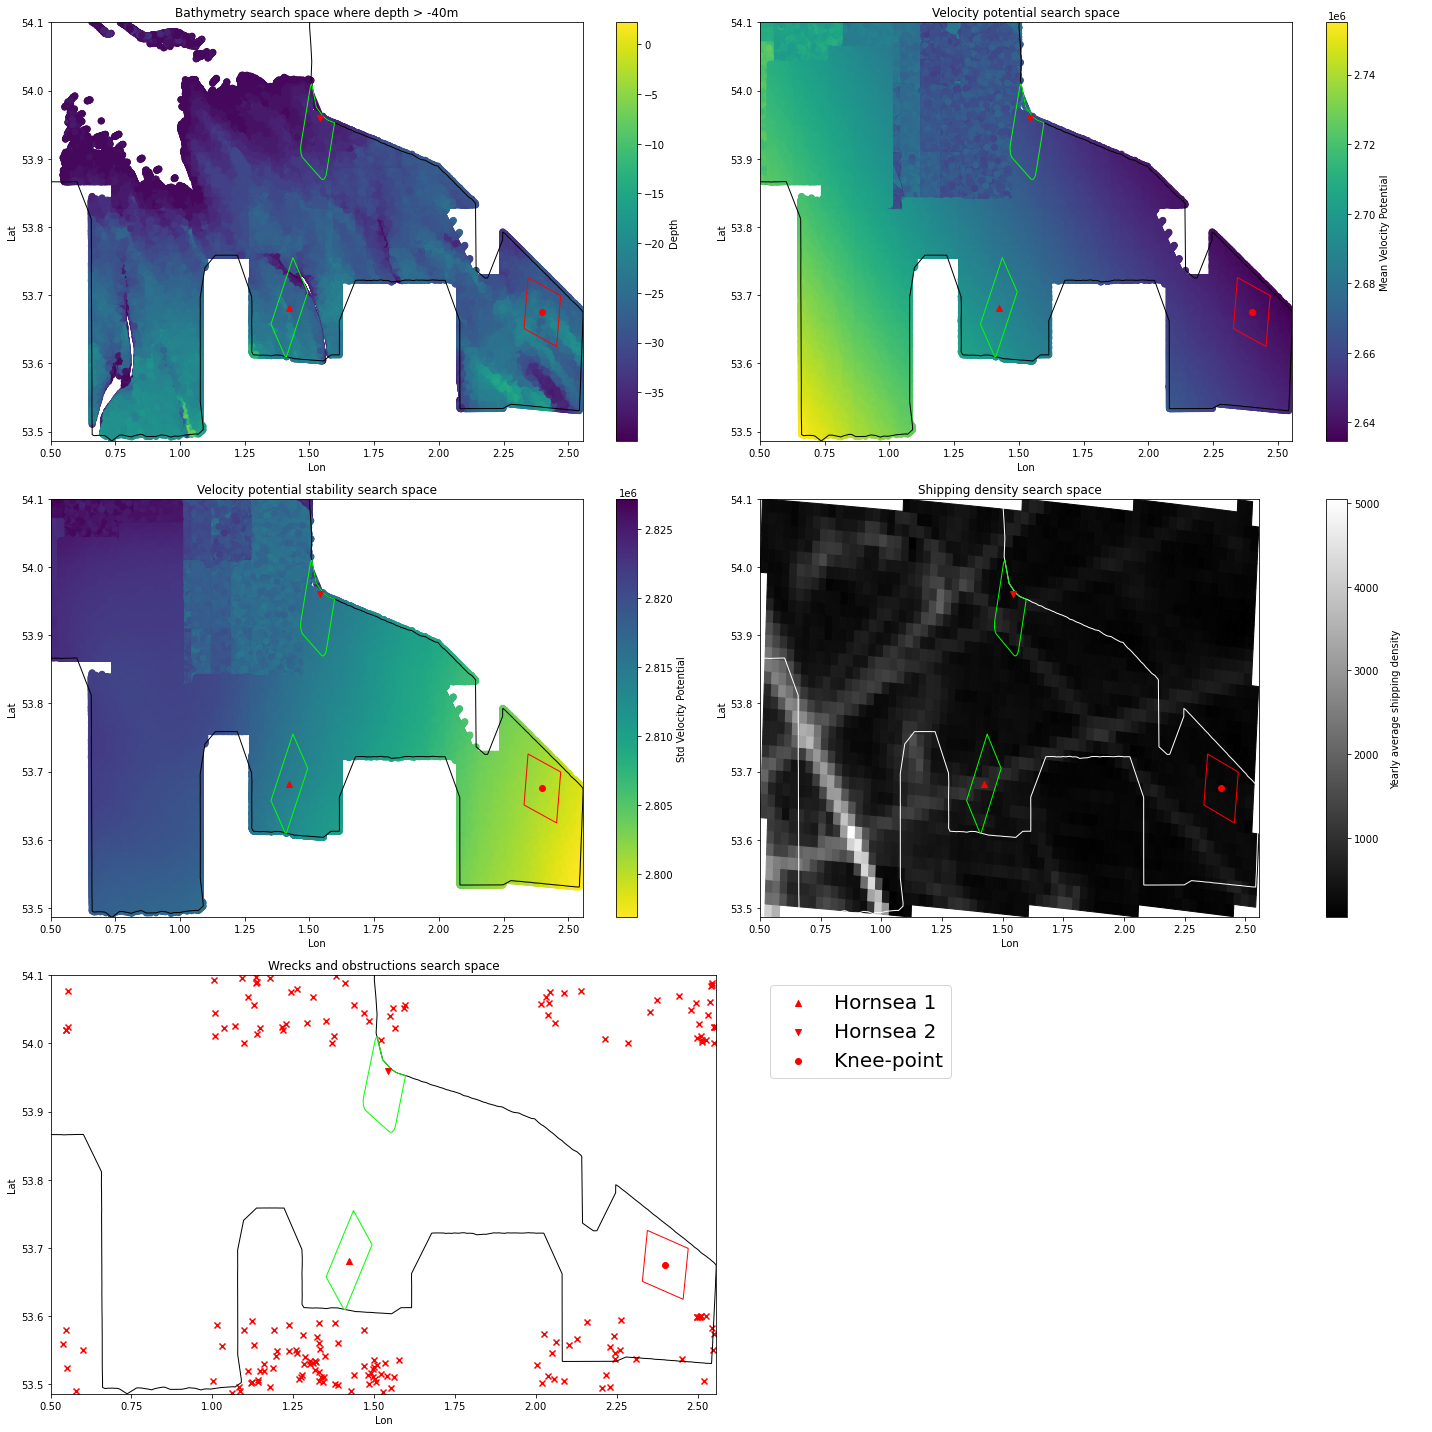

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

# BATHYMETRY
ax = axes[0, 0]
ax.set_title("Bathymetry search space where depth > -40m")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(
    admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis"
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(
        row["center_lon"],
        row["center_lat"],
        c="#FF0000",
        marker=row["Rank marker"],
        label=row["Name"],
    )
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label("Depth")

# VELOCITY POTENTIAL
ax = axes[0, 1]
ax.set_title("Velocity potential search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(
    mean_velocity_potential["Lon"],
    mean_velocity_potential["Lat"],
    c=mean_velocity_potential["Mean Velocity Potential"],
    cmap="viridis",
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(
        row["center_lon"],
        row["center_lat"],
        c="#FF0000",
        marker=row["Rank marker"],
        label=row["Name"],
    )
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label("Mean Velocity Potential")

# VELOCITY POTENTIAL STABILITY
ax = axes[1, 0]
ax.set_title("Velocity potential stability search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
map = ax.scatter(
    velocity_potential_stability["Lon"],
    velocity_potential_stability["Lat"],
    c=velocity_potential_stability["Std Velocity Potential"],
    cmap="viridis_r",
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(
        row["center_lon"],
        row["center_lat"],
        c="#FF0000",
        marker=row["Rank marker"],
        label=row["Name"],
    )
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label("Std Velocity Potential")

# SHIPPING DENSITY
ax = axes[1, 1]
ax.set_title("Shipping density search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
minc, maxc = shipping_density["yearly_avg"].min(), shipping_density["yearly_avg"].max()
# calculate steps between min and max
diff = maxc - minc
for idx, row in shipping_density.iterrows():
    polygon = row["shapely_polygon"]

    # get percentage colours[idx] is between min and max
    i = (row["yearly_avg"] - minc) / diff
    rgb = (int(255 * i), int(255 * i), int(255 * i))
    html = "#%02x%02x%02x" % rgb

    patch = PolygonPatch(polygon, fc=html, ec=html, fill=True)
    ax.add_patch(patch)
ax.add_patch(PolygonPatch(map_polygon, fc="#000000", ec="#ffffff", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(
        row["center_lon"],
        row["center_lat"],
        c="#FF0000",
        marker=row["Rank marker"],
        label=row["Name"],
    )
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)
cmap = matplotlib.cm.binary_r
norm = matplotlib.colors.Normalize(
    vmin=shipping_density["yearly_avg"].min(), vmax=shipping_density["yearly_avg"].max()
)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.1)
cbar.set_label("Yearly average shipping density", labelpad=12.0)

# WRECKS AND OBSTRUCTIONS
ax = axes[2, 0]
ax.set_title("Wrecks and obstructions search space")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.scatter(
    wrecks_and_obstructions["longitude"],
    wrecks_and_obstructions["latitude"],
    c="red",
    marker="x",
)
ax.add_patch(PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False))
for idx, row in combined_results.iterrows():
    polygon, c = boundary_patches[idx]
    patch = PolygonPatch(polygon, fc=c, ec=c, fill=False)
    ax.add_patch(patch)
    ax.scatter(
        row["center_lon"],
        row["center_lat"],
        c="#FF0000",
        marker=row["Rank marker"],
        label=row["Name"],
    )
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# empty subplot to store legend
ax = axes[2, 1]
handles, labels = axes[2, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left", fontsize=20)
ax.axis("off")

plt.tight_layout()
plt.show()


## Improvements
* Determine % improvements of evolved solutions over existing solutions.

In [82]:
improved = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "turbnum",
        "depth",
        "Velocity Potential",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "Comparison sitename",
        "Velocity Potential Change",
        "Stability Change",
        "Shipping Density Change",
        "Wrecks and Obstructions Change",
        "kneepoint",
    ]
)

# compare all solutions against hornsea1 and hornsea2
for known in known_solutions:
    sitename = (
        "Hornsea 1"
        if problem.types[3].decode(known.variables[3]) == 174
        else "Hornsea 2"
    )
    known_objs = known.objectives

    for sol in minimise_solutions:
        sol_objs = sol.objectives

        # get % difference between known and solution objectives
        diff = np.divide(np.subtract(known_objs, sol_objs), known_objs)
        # replace nan with 0 in diff
        diff = np.nan_to_num(diff, nan=0.0)

        # convert diff to percentage
        diff = np.multiply(diff, 100)
        # round diff to 2 decimal places
        diff = np.round(diff, 2)
        # invert diff
        diff = np.multiply(diff, -1)
        # add % symbol to diff
        diff = np.char.add(diff.astype(str), "%")

        decision_vars = []
        decoders = problem.types
        for i, var in enumerate(sol.variables):
            decoder = decoders[i]
            decision_vars += [
                decoder.decode(var),
            ]

        depth = sol.constraints[1]

        if hasattr(sol, "kneepoint"):
            kneepoint = True
        else:
            kneepoint = False

        improved.loc[len(improved.index)] = [
            *decision_vars,
            depth,
            *sol_objs,
            sitename,
            *diff,
            kneepoint,
        ]

# drop duplicate lat/lon from improved
improved = improved.drop_duplicates(
    subset=["center_lon", "center_lat", "Comparison sitename"]
)


C:\Users\zacha\AppData\Local\Temp\ipykernel_22660\1876995531.py:34: RuntimeWarning: invalid value encountered in true_divide
  diff = np.divide(np.subtract(known_objs, sol_objs), known_objs)


In [83]:
known_solutions_decoded


,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,depth,Rank,Rank marker,Wrecks marker,Wrecks color,Name,IsKnown
0,49.0,1.422626,53.681258,174,2.690312e+06,2.814096e+06,52.433040,0,-64.0,1,v,o,r,Hornsea 1,True
1,247.0,1.541901,53.959745,165,2.662278e+06,2.815642e+06,10.534137,1,-39.7,0,o,v,g,Hornsea 2,True


In [84]:
improved


,rotation,center_lon,center_lat,turbnum,depth,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,Comparison sitename,Velocity Potential Change,Stability Change,Shipping Density Change,Wrecks and Obstructions Change,kneepoint
0,348.192542,2.399824,53.675322,167,-29.3,-2.641648e+06,2.800567e+06,9.089156,0,Hornsea 1,-1.81%,-0.48%,-82.67%,-0.0%,True
1,348.192542,2.399824,53.675322,167,-29.3,-2.641648e+06,2.800567e+06,9.089156,0,Hornsea 2,-0.77%,-0.54%,-13.72%,-100.0%,True
